# Import

Run from 7/8/2020

In [1]:
import sys
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

#sys.path.append('/home/stacyste/Documents/Research/OverloadedSignaling/Simulations')
#from simViz_R0 import *

In [2]:
%load_ext autoreload
%autoreload 2

# Functions

In [3]:
def getSignalerDIYUtility(dfRow):
    signalerLoc = dfRow['signalerLocation']
    targetDict = dfRow['targetDictionary']
    goal = dfRow['intention']
    goalLocation = [loc for loc, trg in targetDict.items() if trg==goal][0]
    
    getDistance = lambda a, b: abs(a-b)
    getCost = lambda startCoords, endCoords: -sum([getDistance(p, q) for p, q in zip(startCoords, endCoords)])
    
    cost = getCost(signalerLoc, goalLocation)
    reward = 8
    utility = cost+reward
    return(utility)

In [4]:
def getProportionTargetReached(df):
    propTrialsTargetReached = pd.DataFrame(columns=['signaler', 'receiver'])
    getPropTrue =  lambda colName: df[colName].value_counts(normalize=True).loc[True] if (True in df[colName].value_counts(normalize=True).index) else 0.0

    sToGoal = [x for x in df.columns if 'sAchievesGoal' in x]
    rToGoal = [x for x in df.columns if 'rAchievesGoal' in x]
    
    for sToGoalColumn, rToGoalColumn in zip(sToGoal, rToGoal):
        colName = re.findall(r"[A-Z]+_S[0-9]R[0-9]", sToGoalColumn)[0]+'_C0R' if 'C0R' in sToGoalColumn else re.findall(r"[A-Z]+_S[0-9]R[0-9]", sToGoalColumn)[0]
        propTrialsTargetReached.loc[colName] = [getPropTrue(sToGoalColumn), getPropTrue(rToGoalColumn)]

    propTrialsTargetReached['total'] = propTrialsTargetReached['signaler'] + propTrialsTargetReached['receiver']

    propTrialsTargetReached['marginOfErrorS'] =  1.96*np.sqrt((propTrialsTargetReached['signaler']*(1-propTrialsTargetReached['signaler']))/df.shape[0])
    propTrialsTargetReached['marginOfErrorR'] =  1.96*np.sqrt((propTrialsTargetReached['receiver']*(1-propTrialsTargetReached['receiver']))/df.shape[0])

    return(propTrialsTargetReached)

In [5]:
def plotAccuracyStackedBars(df, save=False, filename='./accuracies.png', rColor = '#484D60', sColor = '#9FA5BD', fSize = (7,6)):
    fig = plt.figure(figsize =fSize)
    ax = fig.add_axes([0,0,1,1])
    width=.5
    
    modelNames = list(df.index)
    y_signalerAchievesGoal = df['signaler'].values
    y_receiverAchievesGoal = df['receiver'].values
    me_rec = df['marginOfErrorR']
    me_sig = df['marginOfErrorS']
    
    
    p1 = plt.bar(modelNames, y_receiverAchievesGoal, width, yerr = me_rec, label = 'Receiver', color = rColor,edgecolor='white')
    p2 = plt.bar(modelNames, y_signalerAchievesGoal, width,yerr = me_sig, label = 'Signaler', color = sColor, edgecolor='white',bottom=y_receiverAchievesGoal)
    
    ax.set_yticks([0,.5,1])
    ax.set_xticklabels(modelNames, rotation=90)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    if save:
        fig.savefig(filename,dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
def getPercentFromOptimalUtilityDF(df):
    percentFromOptimalUtil = pd.DataFrame(index=df.index)
    utilityColumns = [x for x in df.columns if 'utility' in x]
    
    for utilityName in utilityColumns:
        u_optimal = 'CentralControl_utility'
        percentFromOptimalUtil[utilityName] = 100.0*(df[utilityName]/df[u_optimal])#df[utilityName]-df[u_optimal] #
    return(percentFromOptimalUtil)

In [7]:
def getUtilityDifferenceSummaryStatistics(df):
    summaryDF = pd.DataFrame(df.mean(axis=0)).rename(columns={0:'means'})
    summaryDF['stds'] = df.std(axis=0)
    numObs = df.shape[0]
    summaryDF['marginOfError'] = 1.96*summaryDF['stds']/np.sqrt(numObs)
    summaryDF['CI_low'] = summaryDF['means'] - summaryDF['marginOfError']
    summaryDF['CI_high'] = summaryDF['means'] + summaryDF['marginOfError']
    return(summaryDF)

# Processing

In [8]:
sim_r0 = pd.read_pickle('./simulation_costlessReceiver_a4_r8_seed423_2-9ItemFullVocab.pkl')

In [9]:
sim_r0.shape

(2000, 28)

In [10]:
dfr0 = sim_r0.copy(deep=True)
communicationDF = dfr0.copy().loc[dfr0['CentralControl_actor'] == 'receiver']
dlen = lambda x: len(x['targetDictionary'])
communicationDF['nTargets'] = communicationDF.apply(dlen, axis=1) 

In [11]:
dfr0['DIYUtility'] = dfr0.apply(getSignalerDIYUtility, axis=1)

In [12]:
targetReached = getProportionTargetReached(dfr0)
targetReached

,signaler,receiver,total,marginOfErrorS,marginOfErrorR
RSA_S0R0,0.0000,0.576,0.5760,0.000000,0.021659
RSA_S1R1,0.1635,0.620,0.7835,0.016208,0.021273
IW_S1R1,0.1635,0.656,0.8195,0.016208,0.020820


In [13]:
modelNames = ['RSA_S0R0', 'RSA_S1R1', 'IW_S1R1']

In [14]:
dfItems = dfr0

In [15]:
accuracy = pd.DataFrame(index=modelNames)
accuracyME = pd.DataFrame(index=modelNames)

utility = pd.DataFrame()
utilityME = pd.DataFrame()

minItems = min(dfItems['nTargets'])
maxItems = max(dfItems['nTargets'])+1

for itemSetSize in range(minItems, maxItems):
    df_item = dfItems.loc[dfItems['nTargets'] == itemSetSize]
    print("items: ", itemSetSize, 'data points: ', df_item.shape[0])

    df_acc = getProportionTargetReached(df_item)
    accLabel = 'recAcc_' + str(itemSetSize)
    accuracy[accLabel] = df_acc['receiver']
    meLab = 'ME_'+ str(itemSetSize)
    accuracyME[meLab] = df_acc['marginOfErrorR']

    df_util = getPercentFromOptimalUtilityDF(df_item)
    utilSummary = getUtilityDifferenceSummaryStatistics(df_util)
    utilLabel = 'util' + str(itemSetSize)
    utility[utilLabel] = utilSummary['means']
    utilityME[meLab] = utilSummary['marginOfError']
#return(accuracy.transpose(), accuracyME.transpose(),utility.transpose(), utilityME.transpose())

items:  2 data points:  269
items:  3 data points:  253
items:  4 data points:  235
items:  5 data points:  271
items:  6 data points:  237
items:  7 data points:  264
items:  8 data points:  217
items:  9 data points:  254


In [16]:
utility

,util2,util3,util4,util5,util6,util7,util8,util9
RSA_S0R0_utility,86.617100,79.051383,71.063830,54.612546,51.054852,39.772727,43.778802,32.677165
RSA_S1R1_utility,100.000000,97.529644,91.223404,75.922509,65.031646,52.840909,50.403226,41.289370
IW_S1R1_utility,100.000000,98.913043,93.404255,82.841328,69.198312,63.162879,51.900922,42.667323
CentralControl_utility,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
DIYSignaler_utility,18.959108,12.549407,11.276596,13.791513,15.084388,20.265152,13.997696,16.929134


In [17]:
accuracy.transpose()

,RSA_S0R0,RSA_S1R1,IW_S1R1
recAcc_2,0.866171,1.000000,1.000000
recAcc_3,0.790514,0.952569,0.968379
recAcc_4,0.710638,0.863830,0.889362
recAcc_5,0.546125,0.675277,0.745387
recAcc_6,0.510549,0.527426,0.573840
recAcc_7,0.397727,0.375000,0.477273
recAcc_8,0.437788,0.313364,0.327189
recAcc_9,0.326772,0.204724,0.212598


In [18]:
def plotMetricByItem(accDf, meDF, save = False, filename = './acc.png', yAxisLabel = 'Proportion successful communication', yTicks = [0,.1, .2, .3, .4, .5,.6, .7, .8, .9, 1], fSize= (8,5),minItems = 2, maxItems = 9):
    fig = plt.figure(figsize =fSize)
    ax = fig.add_axes([0,0,1,1])
    labelDict = {'RSA_S0R0': 'Naive RSA', 
                'RSA_S1R1': 'Pragmatic RSA', 
                 'IW_S1R1': 'Pragmatic IW', 
                 'DIY Signaler': 'Signaler Does', 
                 'Central Control': 'Optimal'}

    colorDict = {'RSA_S0R0': '#feb954', 
                'RSA_S1R1': '#fed554', 
                 'IW_S1R1': '#b10d2f', 
                 'DIY Signaler': '#000650', 
                 'Central Control': '#555555'} 

    modelLabels = accDf.columns

    x = [a for a in range(minItems, maxItems+1)]

    for modelLabel in modelLabels:
        plt.errorbar(x, accDf[modelLabel].values, yerr = meDF[modelLabel].values, color = colorDict[modelLabel],label=labelDict[modelLabel], linewidth=3)
    plt.xlabel('Number of Items')
    plt.ylabel(yAxisLabel)
    plt.legend(loc='best')
    ax.set_yticks(yTicks)
    ax.tick_params(labelsize=24)
    if save:
        fig.savefig(filename,dpi=300, bbox_inches='tight')
    plt.show()

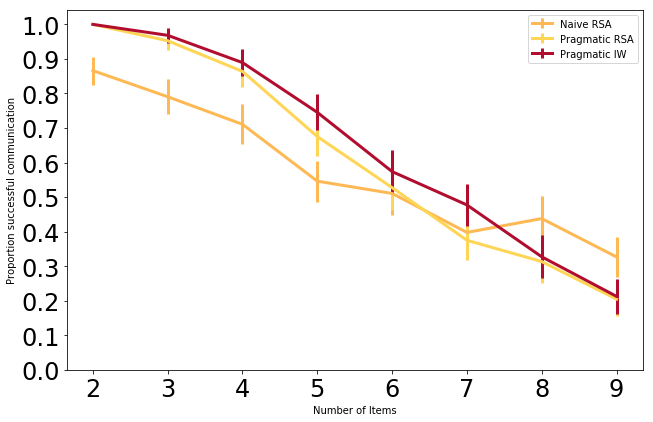

In [19]:
plotMetricByItem(accuracy.transpose(), accuracyME.transpose(), save=True, filename = './successfulCommunicationCostlessReceiver.png')

In [20]:
fUtil = utility.transpose()
fUtil.columns = ['RSA_S0R0', 'RSA_S1R1', 'IW_S1R1', 'Central Control', 'DIY Signaler']
fUtilMe = utilityME.transpose()
fUtilMe.columns = ['RSA_S0R0', 'RSA_S1R1', 'IW_S1R1', 'Central Control', 'DIY Signaler']

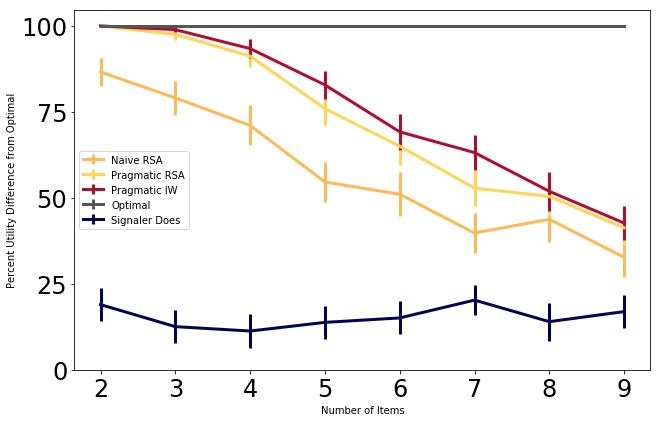

In [21]:
plotMetricByItem(fUtil, fUtilMe,yTicks = [0,25, 50, 75, 100],yAxisLabel = 'Percent Utility Difference from Optimal', save=True, filename = './utilityPercentCostlessReceiver.png')